In [13]:
import lightkurve as lk 
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt

from funcs.flares import flare_factor


def get_flare_energy(ed, ederr, teff, tefferr, radius, radiuserr, wav, resp):
    """Sample the posterior distribution of the flare energy using random samples on ED, 
    and teff and radius with Gaussian errors.

    Parameters
    ----------
    ed : float
        The ED of the flare.
    ederr : float
        The error on the ED of the flare.
    teff : float
        The effective temperature of the star in K.
    tefferr : float
        The error on the effective temperature of the star in K.
    radius : float
        The radius of the star in solar radii.
    radiuserr : float
        The error on the radius of the star in solar radii.
    wav : array
        The wavelengths of the TESS response function.
    resp : array
        The response of the TESS response function.

    Returns
    -------
    mean_bol_energy : float
        The mean bolometric flare energy in erg.
    std_bol_energy : float
        The standard deviation of the bolometric flare energy in erg.
    """
    teff = np.random.normal(teff, tefferr, 500)
    radius = np.random.normal(radius, radiuserr, 500)
    eds = np.random.normal(ed, ederr, 500)
    # calculate the bolometric flare energy for each sample
    ffactor = flare_factor(teff.reshape((500,1)), 
                                 radius.reshape((500,1)), wav, resp,  
                                 tflare=10000)
    
    bol_energies = (ffactor * np.random.choice(eds, 500) * u.s).value

    # calculate the mean and standard deviation of the bolometric flare energy
    mean_bol_energy = np.mean(bol_energies)
    std_bol_energy = np.std(bol_energies)
    mean_ffactor = np.mean(ffactor)  

    return mean_bol_energy, std_bol_energy, mean_ffactor

# GET STELLAR AND PLANET PARAMETERS -----------------------------------------------------

hip67522params = pd.read_csv("../data/hip67522_params.csv")

period = hip67522params[hip67522params.param=="orbper_d"].val.values[0]
midpoint = hip67522params[hip67522params.param=="midpoint_BJD"].val.values[0]
teff = hip67522params[hip67522params.param=="teff_K"].val.values[0]
tefferr = hip67522params[hip67522params.param=="teff_K"].err.values[0]
radius = hip67522params[hip67522params.param=="radius_rsun"].val.values[0]
radiuserr = hip67522params[hip67522params.param=="radius_rsun"].err.values[0]



In [61]:
# GET TESS FLARES FROM ILIN+2024 AND CALCULATE ENERGIES -------------------------------------

# read the TESS flares
hip67522tess = pd.read_csv("../data/hip67522_tess_flares.csv")

# read TESS response function
tess_resp = pd.read_csv("../data/tess-response-function-v2.0.csv", skiprows=7, 
                        names=["wav", "resp"], header=None)
wav, resp = tess_resp.wav.values, tess_resp.resp.values

# calculate the flare energies
res = hip67522tess.apply(lambda x: get_flare_energy(x["ed_rec"], x["ed_rec_err"], teff, 
                                                    tefferr, radius, radiuserr, wav, resp),
                                                    axis=1)

# write res to two columns in a new dataframe using the right column names for the FFD object
hip67522tessffd = pd.DataFrame(res.values.tolist(), columns=["ed_rec", "ed_rec_err", "ffactor"])   
hip67522tessffd["phase"] = hip67522tess["phase"].values
hip67522tess.head()

,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec,dur,...,TIC,qcs,mission,tstamp,lc_n,w,mask_pos_outliers_sigma,real,note,helpid
0,5677.0,5685.0,274195.0,274203.0,1608.286861,1608.297972,2.355643,0.189734,0.003271,0.011111,...,166527623,11,TESS,2022_07_30,1.0,61.0,2.5,1.0,NaN,HIP 67522_TESS_11
1,6675.0,6686.0,275193.0,275204.0,1609.672965,1609.688243,6.089314,0.248886,0.008170,0.015278,...,166527623,11,TESS,2022_07_30,1.0,61.0,2.5,1.0,NaN,HIP 67522_TESS_11
2,512.0,522.0,797352.0,797362.0,2334.893506,2334.907395,3.589193,0.323217,0.005232,0.013889,...,166527623,38,TESS,2022_07_30,2.0,61.0,2.5,1.0,NaN,HIP 67522_TESS_38
3,571.0,590.0,797411.0,797430.0,2334.975450,2335.001839,16.116874,0.054201,0.011215,0.026389,...,166527623,38,TESS,2022_07_30,2.0,61.0,2.5,1.0,NaN,HIP 67522_TESS_38
4,711.0,719.0,797551.0,797559.0,2335.169895,2335.181006,2.889699,0.203887,0.005448,0.011111,...,166527623,38,TESS,2022_07_30,2.0,61.0,2.5,1.0,NaN,HIP 67522_TESS_38


In [15]:
lcs = lk.search_lightcurvefile("HIP 67522", mission="TESS")
lcs

/tmp/ipykernel_187309/3055158686.py:1: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  lcs = lk.search_lightcurvefile("HIP 67522", mission="TESS")


#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 11,2019,SPOC,120,166527623,0.0
1,TESS Sector 38,2021,SPOC,120,166527623,0.0
2,TESS Sector 64,2023,SPOC,20,166527623,0.0
3,TESS Sector 64,2023,SPOC,120,166527623,0.0
4,TESS Sector 11,2019,TESS-SPOC,1800,166527623,0.0
5,TESS Sector 38,2021,TESS-SPOC,600,166527623,0.0
6,TESS Sector 64,2023,TESS-SPOC,200,166527623,0.0
7,TESS Sector 11,2019,QLP,1800,166527623,0.0
8,TESS Sector 38,2021,QLP,600,166527623,0.0


In [16]:
lcls = lcs[[0,1,3]].download_all()
lcdict = {l.sector: l for l in lcls}
lcdict

{11: <TessLightCurve length=18187 LABEL="TIC 166527623" SECTOR=11 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
        time             flux      ...   pos_corr1      pos_corr2   
                     electron / s  ...      pix            pix      
        Time           float32     ...    float32        float32    
 ------------------ -------------- ... -------------- --------------
 1596.7826275097552            ——— ... -1.0144706e-03 -6.0492292e-02
 1596.7840164082984            ——— ... -5.2158110e-04 -6.6831551e-02
 1596.7854053063754            ——— ...  2.2561252e-03 -5.8883667e-02
  1596.786794204919            ——— ... -2.9421474e-03 -5.8576666e-02
 1596.7881831034626            ——— ... -1.0587571e-03 -6.2048770e-02
 1596.7895720015401            ——— ...  2.5658447e-03 -6.4064763e-02
 1596.7909609000828            ——— ... -1.3992556e-03 -5.1135346e-02
 1596.7923497981603            ——— ...  1.6684376e-03 -6.5228611e-02
  1596.793738696704            ——— ... -6.7799765e-04 -5.4319058e-02


/tmp/ipykernel_187309/1233603065.py:10: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcdict[row.qcs].PDCSAP_FLUX.normalize().remove_nans()


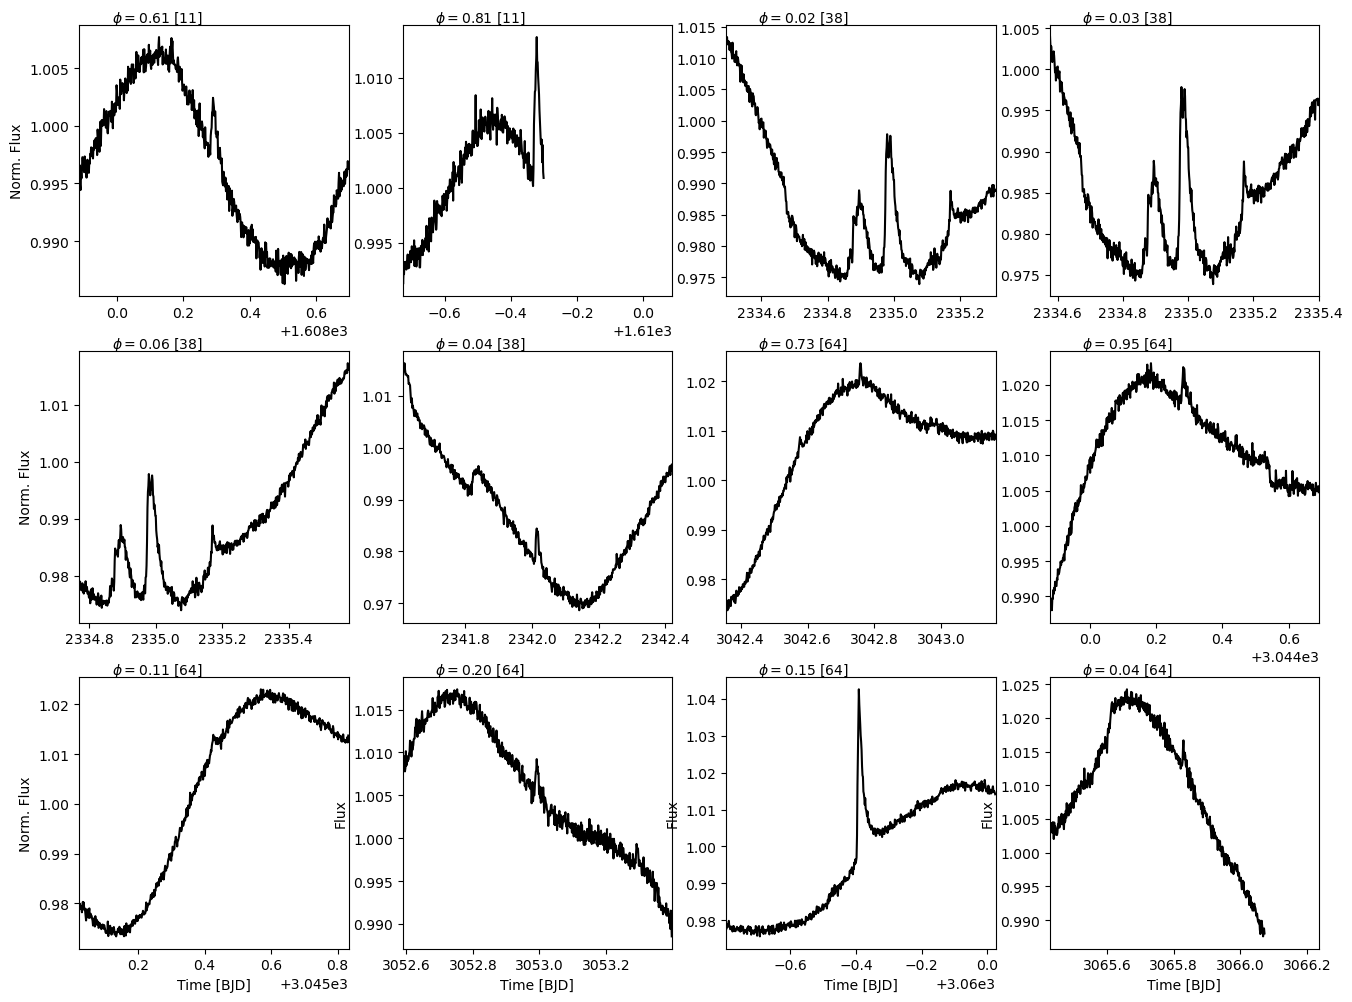

In [134]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16,12))
axes = axes.flatten()

# sort hip67522tess by phase
hip67522tess = hip67522tess.sort_values("phase")

offset=0.4

for i, row in hip67522tess.iterrows():
    lc = lcdict[row.qcs].PDCSAP_FLUX.normalize().remove_nans()

    # restrict the light curve to the flare times tstart and tstop + 0.1 day left and right
    tstart, tstop = row.tstart, row.tstop
    lc = lc[(lc.time.value > tstart-offset) & (lc.time.value < tstop+offset)]
    ax = axes[i]
    ax.plot(lc.time.value, lc.flux, label=f"Phase {row.phase:.2f}", c="k")
    plt.text(0.12, 1.01, fr"$\phi={row.phase:.2f}$ [{row.qcs}]", transform=ax.transAxes)
    # ax.set_title(f"Phase {row.phase:.2f}")
    
    ax.set_xlim(tstart-offset, tstop+offset)

# put x-axis label on the bottom rows
for ax in axes[-4:]:
    ax.set_xlabel("Time [BJD]")
    ax.set_ylabel("Flux")

# put y axis label on the left columns
for ax in axes[::4]:
    ax.set_ylabel("Norm. Flux")
    
# increas the horizontal space between the subplots


In [59]:
# get pixel data
tpf = lk.search_targetpixelfile("HIP 67522", mission="TESS")
tpf

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 11,2019,SPOC,120,166527623,0.0
1,TESS Sector 38,2021,SPOC,120,166527623,0.0
2,TESS Sector 64,2023,SPOC,20,166527623,0.0
3,TESS Sector 64,2023,SPOC,120,166527623,0.0
4,TESS Sector 11,2019,TESS-SPOC,1800,166527623,0.0
5,TESS Sector 38,2021,TESS-SPOC,600,166527623,0.0
6,TESS Sector 64,2023,TESS-SPOC,200,166527623,0.0


In [89]:
tpfn = tpf[3].download()

17143 3065.82792424088
2935 3045.42341420531
12832 3059.60427306811
8228 3052.98889388206
1015 3042.75666309214
2111 3044.2789343747


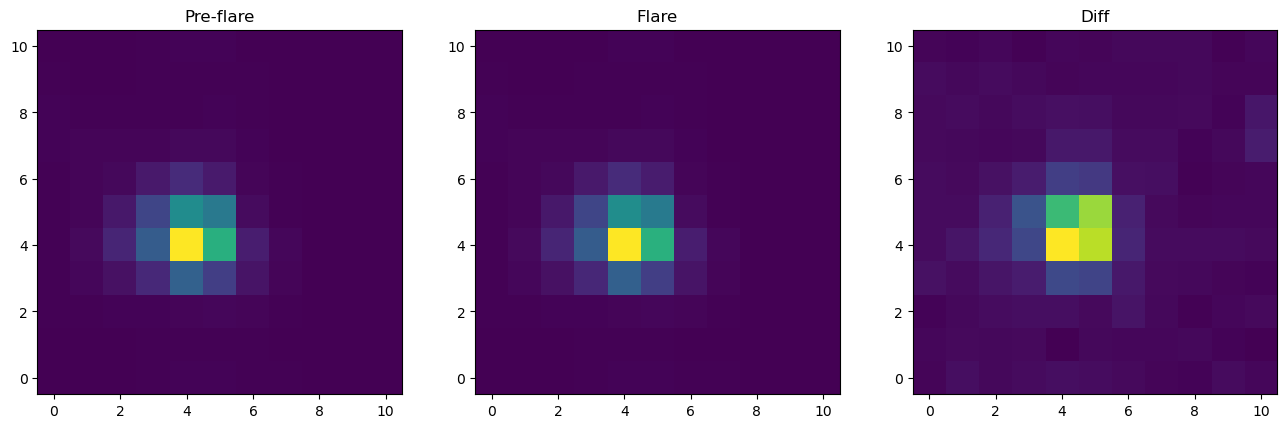

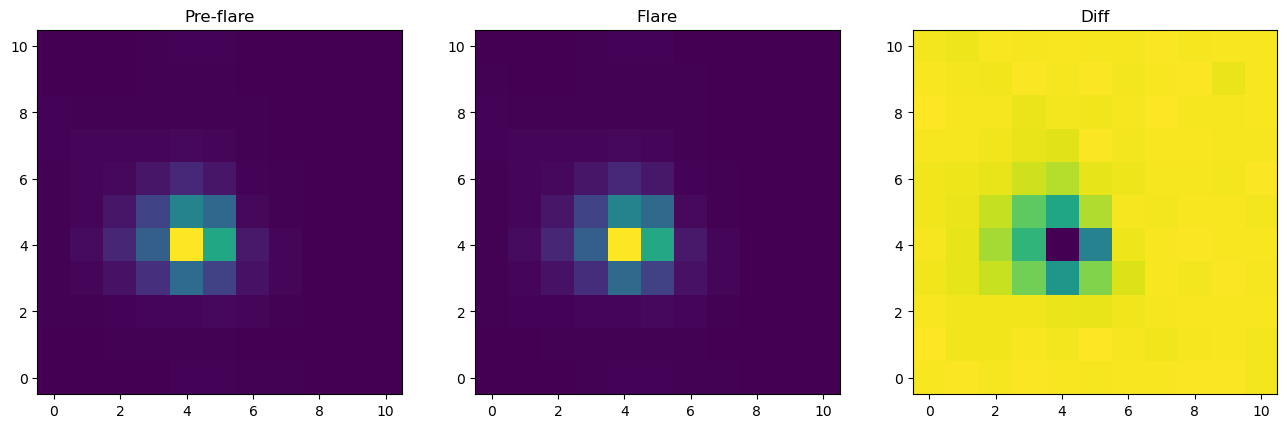

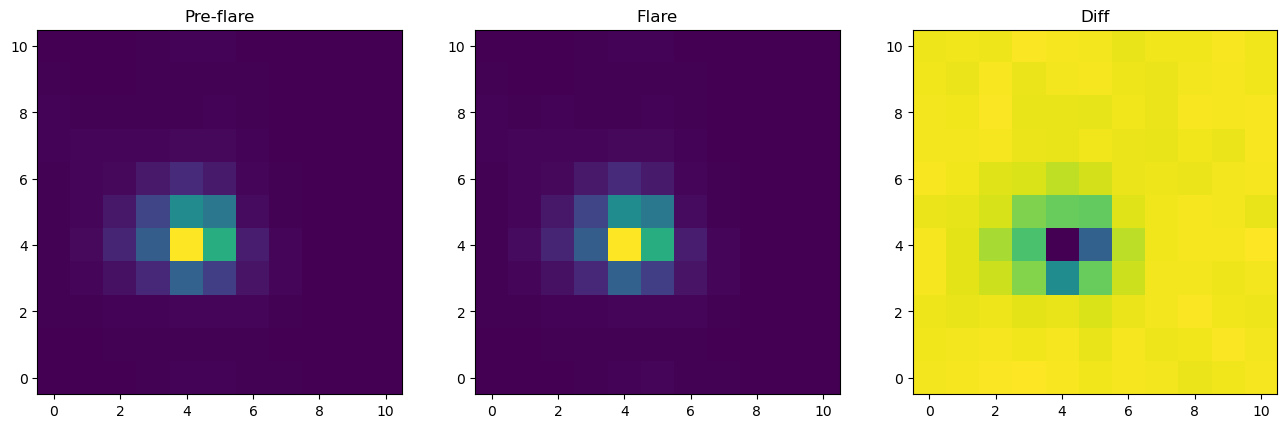

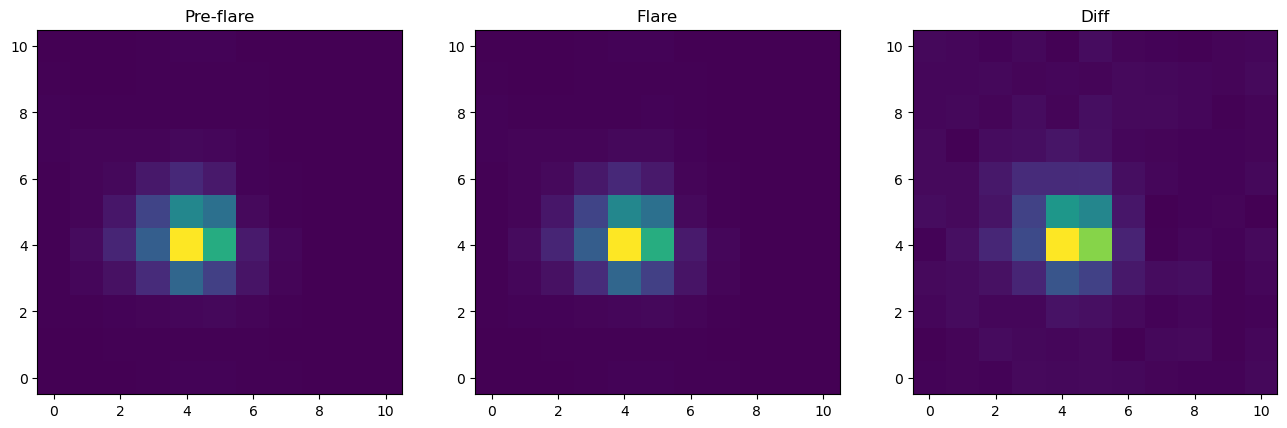

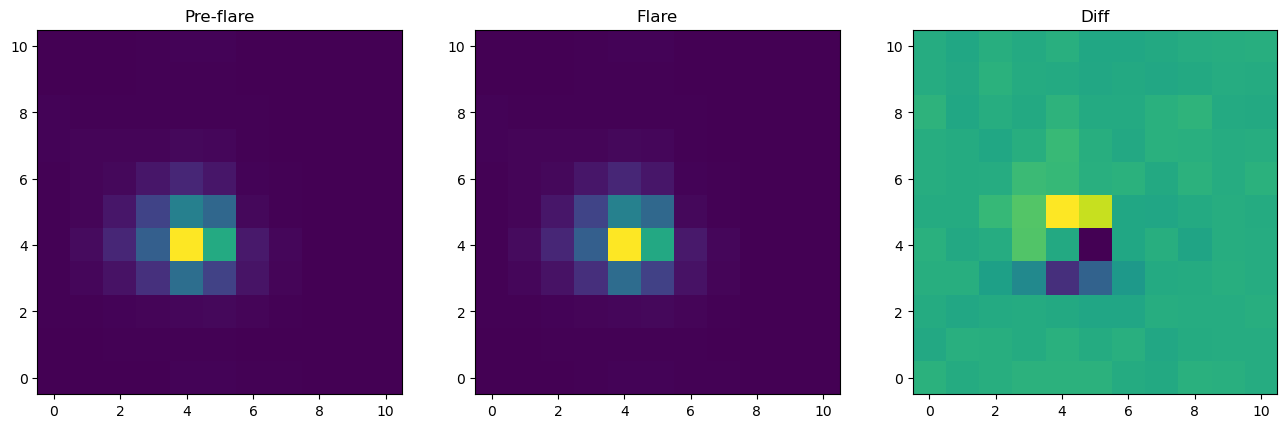

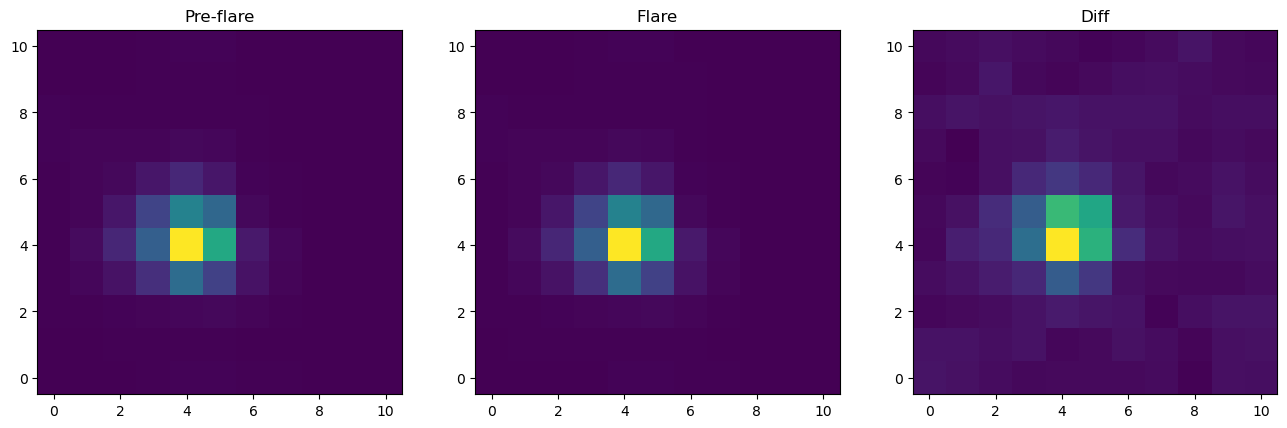

In [107]:
for i, row in hip67522tess[hip67522tess.qcs==64].iterrows():      
    frame = int(row.istart) + 1
    print(frame, row.tstart)
    frame_before = frame - 10
    frame_before_before = frame - 900

    # subtract the pre-flare from the flare frame
    pre_flare = tpfn.flux[frame_before_before:frame_before].value.mean(axis=0)
    flare = tpfn.flux[frame].value
    diff = flare - pre_flare
    

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
    axes = axes.flatten()

    axes[0].imshow(pre_flare, origin="lower", cmap="viridis")

    axes[0].set_title("Pre-flare")
    axes[1].imshow(flare, origin="lower", cmap="viridis")
    axes[1].set_title("Flare")
    axes[2].imshow(diff, origin="lower", cmap="viridis")
    axes[2].set_title("Diff")

# 0 space between subplots
# plt.tight_layout(h_pad=0, w_pad=0, hspace=0, wspace=0)


    # tpfn.plot(aperture_mask=tpfn.pipeline_mask, frame=frame, scale="log", cmap="viridis")

In [ ]:

complc = lk.search_lightcurvefile("TIC 166526944", mission="TESS")
complc

/tmp/ipykernel_187309/4111870531.py:1: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  complc = lk.search_lightcurvefile("TIC 166526944", mission="TESS")


#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 11,2019,SPOC,120,166526944,0.0
1,TESS Sector 11,2019,TESS-SPOC,1800,166526944,0.0
2,TESS Sector 64,2023,TESS-SPOC,200,166526944,0.0
3,TESS Sector 11,2019,QLP,1800,166526944,0.0
4,TESS Sector 38,2021,QLP,600,166526944,0.0
5,TESS Sector 64,2023,QLP,200,166526944,0.0


In [ ]:
lccomp1 = complc[0].download()

(1608.0, 1610.0)

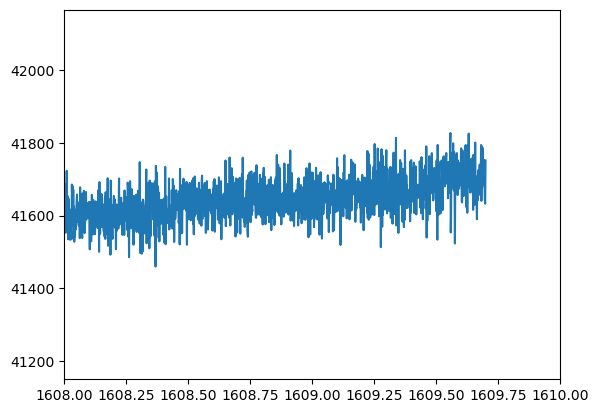

In [115]:
plt.plot(lccomp1.time.value, lccomp1.flux.value)
plt.xlim(1608, 1610)

In [123]:
complc2 = lk.search_lightcurvefile("TIC 166525884", mission="TESS")
complc2

/tmp/ipykernel_187309/4146542768.py:1: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  complc2 = lk.search_lightcurvefile("TIC 166525884", mission="TESS")


#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 38,2021,SPOC,120,166525884,0.0
1,TESS Sector 64,2023,SPOC,120,166525884,0.0
2,TESS Sector 11,2019,TESS-SPOC,1800,166525884,0.0
3,TESS Sector 38,2021,TESS-SPOC,600,166525884,0.0
4,TESS Sector 64,2023,TESS-SPOC,200,166525884,0.0
5,TESS Sector 11,2019,QLP,1800,166525884,0.0
6,TESS Sector 38,2021,QLP,600,166525884,0.0
7,TESS Sector 64,2023,QLP,200,166525884,0.0


In [124]:
complc2 = complc2[1].download()



(3065.5, 3066.6)

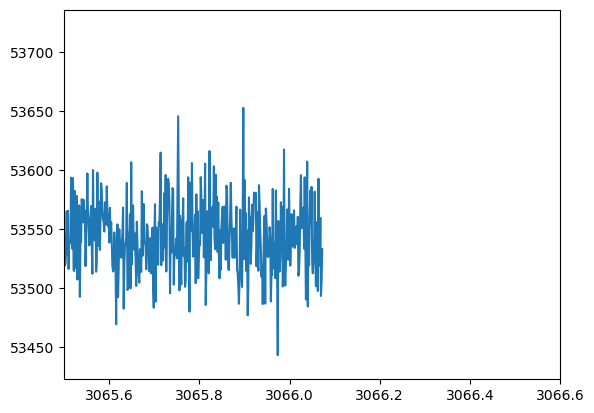

In [133]:
plt.plot(complc2.time.value, complc2.flux.value)
plt.xlim(2334.4, 2335.4)
plt.xlim(2341.5, 2342.5)
plt.xlim(3042.5,3043)
plt.xlim(3044,3045)

plt.xlim(3045,3046)
plt.xlim(3052.4,3053.4)
plt.xlim(3059,3060)
plt.xlim(3065.5,3066.6)